# Kinetics III

This Notebook continues with the analysis of kinetic data obtained in a constant volume batch reactor. It considers the same data set from [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), where we applied a differential method of analysis and linear regression to estimate the reaction order and rate constant for an $A \rightarrow B$ reaction and [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), where we instead used integral analysis and nonlinear regression. In this Notebook, we will continue with the integral analysis example, but we will consider model linearization strategies that allow us to use linear least squares for parameter estimation. We will also consider how certain linearization strategies can improve precision in parameter estimation by avoiding unecessary regression of known parameter values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

```{note}
This problem statement is the same as [Example Problem 01 in Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html#example-problem-01). We will again pursue an integral method of analysis, but we will linearize the resultant models.
```
The following reaction is carried out in a well-mixed, isothermal, constant volume batch reactor. The concentration of species $A$ and $B$ in the tank are initially $C_{A0} = 10 \mathrm{M}$ and $C_{B0} = 0 \mathrm{M}$ at $t = 0$. You may assume that the fluid inside of the reactor has constant density. 
			
$$A \longrightarrow B$$
			
We measure the concentration of species $A$ in this reactor, monitoring how it changes with time. The collected data are tabulated below. 

| time (s) | $C_A \ (\mathrm{mol \ L^{-1}})$ |  time (s)  | $C_A \ (\mathrm{mol \ L^{-1}})$ |
|:--------:|:-------------------------------:|:----------:|:-------------------------------:|
|0         | 10.0                            | 34         | 4.96                            |
|1         | 9.58                            | 55         | 4.10                            |
|2         | 9.21                            | 89         | 3.33                            |
|3         | 8.87                            | 144        | 2.68                            |
|5         | 8.30                            | 233        | 2.13                            | 
|8         | 7.62                            | 377        | 1.69                            |
|13        | 6.79                            | 610        | 1.34                            |
|21        | 5.88                            | 987        | 1.06                            |

You may assume that the rate law for this reaction follows basic, power law kinetics, i.e.:
 
$$r = k{C_A}^{\alpha}$$

where $\alpha$ is a presently unknown integer. Use the data in the above table to determine the reaction order, $\alpha$, and to estimate the rate constant, $k$, as precisely as possible.

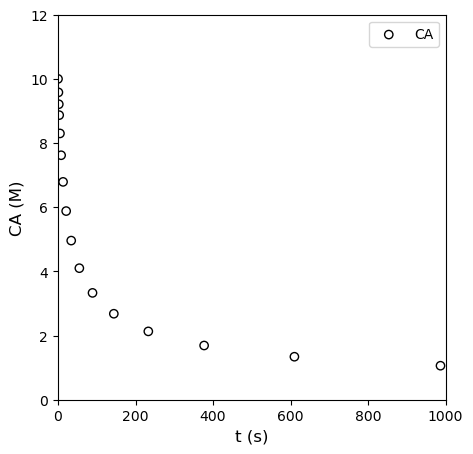

In [2]:
###################################################################################################
# Store experimental time and concentration data in separate arrays                               #
###################################################################################################

tdata  = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]) #experimental measurement time in seconds
CAdata = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])# Concentrations in moles per liter
tfine  = np.linspace(0, max(tdata), 100) #set of times on a finely spaced grid; use for generating smooth line graphs

###################################################################################################
# Graph experimental CA vs t data                                                                 #
###################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

### Solution to Example Problem 01

We want to use the data to determine the rate law and kinetic parameters $(\alpha, k)$. This is an inverse problem, and we need to find a way to extract this information from the data. Since this reaction is overall (not an elementary step), we can at most propose that the rate of reaction depends on temperature (which we capture with a rate constant) and the concentration of the reactant, $A$. At the moment, the reaction order is unknown, and propose general power law kinetics with an unknown reaction order $\alpha$.

$$r = k{C_A}^\alpha$$

As discussed in [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), we can generate a model that describes the functional relationship between $C_A$ and $t$ by solving the material balance on species $A$ in this constant volume batch reactor. We start by writing a material balance on species $A$ in this constant volume batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

For a constant volume reactor, we can divide through by $V$ and move it inside of the derivative:

$$\frac{dC_A}{dt} = R_A$$

For a single reaction, we know that $R_A = -r$, so:

$$\frac{dC_A}{dt} = -r$$

Finally, we have proposed power law kinetics, hence:

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

As in [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), we can obtain a relatively straighforward symbolic solution to the material balance if we assume a constant numerical value for the reaction order $\alpha$. Although we are free to test any numerical value for the reaction order, it is generally most sensible to try integer orders first. If we fail to find a good fit with integer orders, we might also try half orders (1/2, 3/2, etc.) It is generally not advisable to try other fractional orders in a power law expression because there are too many possibilities, and the differences between them become so small that it is hard to determine the best reaction order. Ideally, the reaction orders that we test would be informed by the results of a preliminary differential analysis. For example, in [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), our differential analysis suggested a reaction order of 3.17, which might motivate us to test third order kinetics. This is consistent with our integral analysis in [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), where we found that third order kinetics (by far) gives the best minimum sum of squares when considered alongside first order and second order kinetics.

Below, we recap the solutions to the material balance for first order, second order, and third order kinetics. We will use these as the basis for the remainder of our analysis in this Notebook.

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -kC_A$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-kdt$$

Which gives:

$$C_A = C_{A0}\exp\left(-kt\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$$

#### Third Order Solution

For a third order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^3$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^3}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$$

#### How well do these models describe the observed trends?

Now, we are ready to decide which of these models (if any!) describes our data the best. To summarize, we have 3 models to vet against our data:

**First Order**: $C_A = C_{A0}\exp\left(-kt\right)$

**Second Order**: $C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$

In [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), we took the approach of using numerical optimization tools to minimize the residual sum of squares calculated using each model. In this Notebook, we will instead linearize these models and then use linear least squares for assessing model fit and for parameter estimation.

### Linearized Models

We will often find that the models describing trends of interest -- for example, reactant concentration as a function of time in a batch reactor -- are nonlinear in nature. In many cases, we can apply mathematical transformations that convert these functions to something that is linear. We'll consider such transformations for first order, second order, and third order kinetics, and then we will fit linearized data using linear least squares.

#### First Order Kinetics 

For first order kinetics, we solved the material balance to find:

$$C_A = C_{A0}\exp(-kt)$$

This is a nonlinear function of $k$ and $t$; however, if we take the natural logarithm of both sides, we convert it to the following form:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - kt$$

Studying this expression, we conclude that it is a first order (linear) model that describes how $\ln{(C_A)}$ varies as a function of $t$. If our reaction has first order kinetics, then we should see that a plot of $\ln{(C_A)}$ vs. $t$ should be linear, and we can regress the slope to determine the first order rate constant. if the first order model is correct.  The slope would be equal to $-k$, and the y-intercept would be $\ln{(C_{A0})}$.

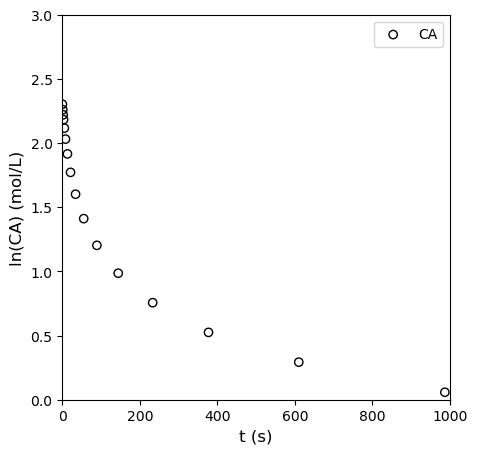

In [3]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, np.log(CAdata), edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 3)
plt.legend()
plt.show()

We can use the graph to visually assess linearity, and we can quickly conclude that $\ln(C_A)$ is not linear in time. This indicates to us that the rate of reaction is not first order in $A$. We can be more quantitative by working through linear regression to estimate the slope, intercept, minimum sum of squares, and associated statistical metrics.  To do so, we would write our model in matrix form, noting that there are two unknown coefficients--the slope and y-intercept--that we can call $\alpha_1$ and $\alpha_2$:

$$\alpha_1t^1 + \alpha_0t^0 = \ln\left(C_A\right)$$

We can put this into the vandermonde form:

$$XA = Y$$

Where $X$ is the vandermonde matrix generated from our time data  (and truncated to include only zero order and first order terms), and $Y$ is the array of values for $\ln(CA)$ measured at various values of $t$.  In the cell below, we perform the regression, overlay the best fit line with the linearized data, and print out statistical metrics. From this, we can see significant deviation from linearity and conclude that the data fit is poor. This should make us confident that the rate of reaction is not first order in $C_A$

m    = -0.0023 +/- 0.0008
b    = 1.8556 +/- 0.2441
SSE  = 2.1351
SST  = 8.5171
MSE  = 0.1334
RMSE = 0.3653
R2   = 0.7493
k1   = 0.0023
CA0  = 6.3956


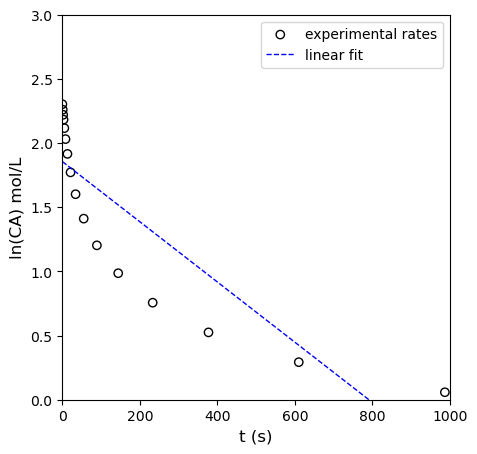

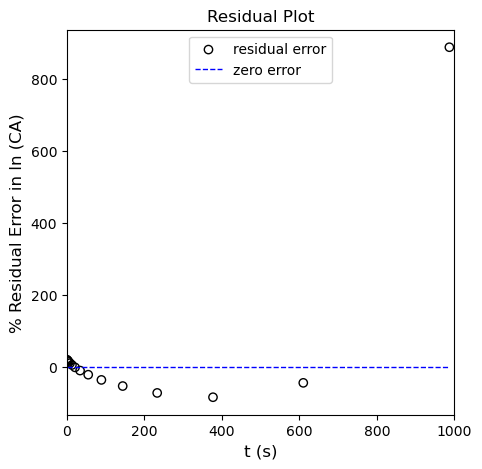

In [4]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(CAdata)
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k1     = -1*m                         #slope is equal to the -k
CA0e   = np.exp(b)                    #y intercept is equal to ln(CA0)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k1', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k1, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4f} +/- {CIm:0.4f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4f} +/- {CIb:0.4f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 1000)
plt.ylim(0, 3)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('ln(CA) mol/L', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 1000)
# plt.ylim(-0.08, 0.08)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (CA)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

From any metric we choose, we can see that the fit here isn't very good. All of our quantitative estimates of model error are large, there is clear, systematic deviation between model and prediction, and we find that $R^2 = 0.75$.

**Second Order Model**

For the second order model, we have:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

We should see linearity here if we plot $\frac{1}{C_A}$ vs $t$.  See below.  Deviation from linearity is clearly observed.

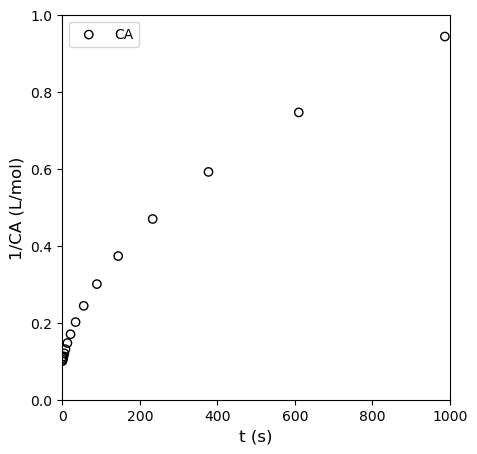

In [5]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, 1/CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.legend(loc = 'upper left')
plt.show()
plt.show()

We should regress coefficients for the linearized second order regardless; it is also useful to calculate the minimum residual sum of squares and various other metrics that can help us to assess goodness of fit using second order kinetics. In this case, the slope of the regressed line is an estimate for the 2nd order rate constant, $k2$, and the y-intercept is an estimate of $1/C_{A0}$

m    = 0.0009 +/- 0.0001
b    = 0.1590 +/- 0.0405
SSE  = 0.0588
SST  = 0.9957
MSE  = 0.0037
RMSE = 0.0606
R2   = 0.9409
k2   = 8.9889E-04
CA0  = 6.2902


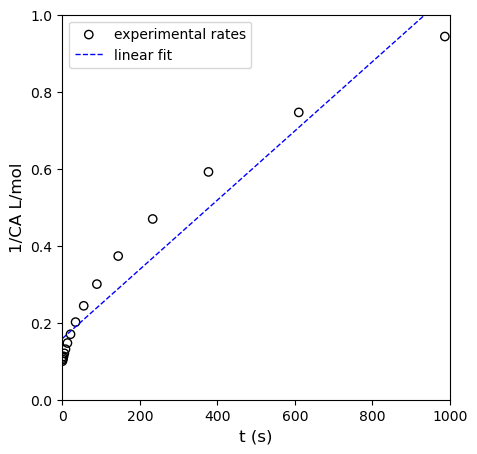

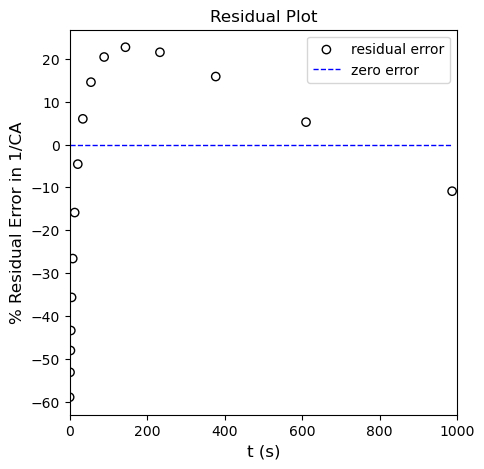

In [6]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/CAdata
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k2     = m                            #slope is equal to k
CA0e   = 1/b                          #y intercept is equal to 1/CA0

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k2', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k2, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4f} +/- {CIm:0.4f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4f} +/- {CIb:0.4f}')
    elif label == 'k2':
        print(f'{label:4s} = {value:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/CA L/mol', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 1000)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/CA', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper right')
plt.show()

As in the first order case, there is curvature apparent in this second order "linearization." Further, there is clear systematic deviation from the model (non-random scatter); this is a sign that the model does not describe our data very well. We do see some improvement in the $R_2$ value (compared to the first order rate of reaction), suggesting that the true kinetics are closer to second order than they are to first order. Still, nothing about these metrics suggest a good fit to the data.

```{note}
With these linearized models, optimal results for the residual sum of squares cannot be compared directly for first order, second order, and third order kinetics. This is because, in each case, the nature of the observable quantity in the linearized model is different. For example, with first order kinetics, our "y" observable is $\ln(C_A)$, whereas for second order kinetics, it is $1/C_A$. Residual sum of squares depends on the magnitude of the quantity being measured -- $\ln(C_A)$ and $1/C_A$ are clearly different quantities, so we cannot directly compare residual sum of squares to assess goodness of fit.
```

#### Third order linearization

For the third order model, we have:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

We should see linearity here if we plot $\frac{1}{2{C_A}^2}$ vs $t$, and the slope, $\alpha_1$, should give us the rate constant.  This is again a linear model:

$$\alpha_1t^1 + \alpha_0t^0 = \frac{1}{2{C_A}^2}$$

We can put this into the vandermonde form:

$$XA = Y$$

m    = 4.4674E-04 +/- 1.1924E-06
b    = 5.2440E-03 +/- 3.7427E-04
SSE  = 0.0000
SST  = 0.2314
MSE  = 0.0000
RMSE = 0.0006
R2   = 1.0000
k3   = 4.4674E-04 +/- 1.1924E-06
CA0  = 9.7646


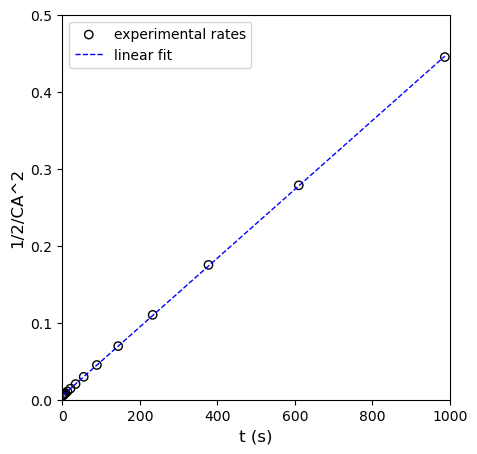

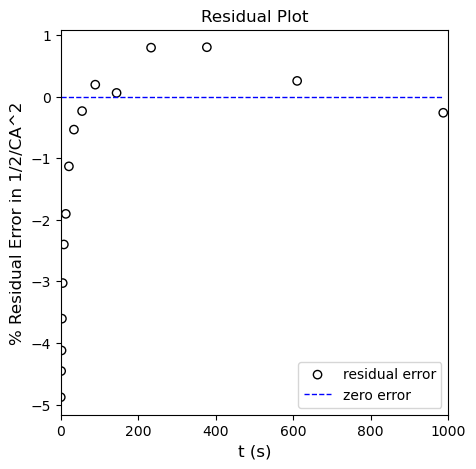

In [7]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/2/CAdata**2
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k3     = m                            #slope is equal to k
CIk3   = CIm                          #confidence interval on k3
CA0e   = np.sqrt(1/2/b)               #y intercept is equal to 1/2CA0^2

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k3', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k3, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4E} +/- {CIm:0.4E}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4E} +/- {CIb:0.4E}')
    elif label == 'k3':
        print(f'{label:4s} = {value:0.4E} +/- {CIk3:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 1000)
plt.ylim(0, 0.5)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/2/CA^2', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 1000)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/2/CA^2', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'lower right')
plt.show()

Based on these results, we would conclude that this is an adequate linearization -- we observe small residual errors, an $R^2$ value near 1, and the data visually appear linear. Based on this, we could reasonably conclude that this reaction rate is third order in species $A$ and that the value of the third order rate constant is:

$$k \approx 4.47 \times 10^{-04} \ \mathrm{L^2 \ mol^{-2} \ min^{-1}}$$

This is not an exact answer -- it is an estimate. In the cell above, we calculated a confidence interval on the slope, finding that our estimate of the slope (which is equal to the rate constant for this case) is better expressed as:

$$k \approx 4.47 \pm 0.012 \times 10^{-04} \ \mathrm{L^2 \ mol^{-2} \ min^{-1}}$$

This is a very precise estimate for the rate constant, which is a consequence of this being a "perfect" data set generated by simulating a batch reactor for an $A \rightarrow B$ reaction that is third order in $A$. It is rare that we will attain this level of precision, and we should consider strategies for reducing the uncertainty in parameter estimates where possible.

### Minimizing Uncertainty by Estimating Fewer Parameters

If we go back to our linearized third order model:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

We see that, as written, it is technically expressed in terms of two unknown coefficients -- a slope and a y-intercept.  In some cases, it may be necessary to regress each of these coefficients. Here, though, we are told in the problem statement that $C_{A0}$ is well-defined and known to be equal to $10\mathrm{M}$. In this case, it does not make sense for us to regress a value for the y-intercept because it is already known. Further, as we increase the number of parameters regressed, we decrease the precision in each parameter that we regress. For an optimization where we already know a parameter, like $C_{A0}$ in this case, it is best if we can avoid adding additional uncertainty by regressing its value. How could we address this?

Two ways:

1. We use the nonlinear regression; with nonlinear regression, we have complete control over the parameters we choose to estimate.
2. We try a different linear transformation that reduces the model to a $y = mx$, wherein the y-intercept is zero and is not regressed.  

We already did nonlinear regression in [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html), so let's try to find a different linearization that would avoid estimating the y-intercept. Our original linearization was:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

Which, in matrix form, looks like:

$$\alpha_1t^1 + \alpha_0t^0 = \frac{1}{2{C_A}^2}$$

Since we actually know $C_{A0}$, we could instead write the following linearization: 

$$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2} = kt$$

In this form, our observable "y" value is given by $\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$. We can plot this quantity vs. $t$. If the kinetics are indeed third order, we will see a linear data set that has a zero y-intercept. We can recast this equation in matrix form:

$$\alpha_1t^1 = \frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$$

$$XA = Y$$

Where $X$ is a vandermonde matrix created from tdata; however, we only keep the first order powers of time here (since there is no zero order coefficient in the model).  $Y$, in this case, is $\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$, and $A$ is only a single coefficient, namely the slope of the line.  See below for implementation. We cannot use `numpy.polyfit()` here since polyfit will insist on estimating the maximum number of coefficients for a given order polynomial. We also cannot rely on `numpy.vander()` to automatically generate the correct Vandermonde matrix for us since there is no way to tell it to include only first order powers of $t$. That said, if we understand the construction and meaning of the terms in the Vandermonde matrix, we can construct the relevant matrices and perform linear least squares as usual. Doing so, we see a small improvement in precision for the estimated value of the third order rate constant, $k3$.

m    = 4.4713E-04 +/- 1.0483E-06
b    = 5.2440E-03 +/- 3.7427E-04
SSE  = 0.0000
SST  = 0.2314
MSE  = 0.0000
RMSE = 0.0006
R2   = 1.0000
k3   = 4.4713E-04 +/- 1.0483E-06


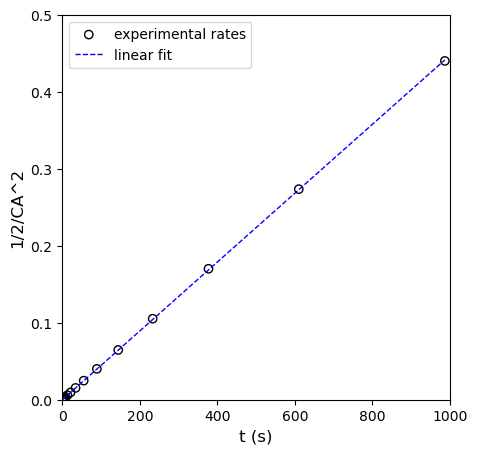

C:\Users\jqbon\AppData\Local\Temp\ipykernel_12196\1692577138.py:85: RuntimeWarning: invalid value encountered in divide
  plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')


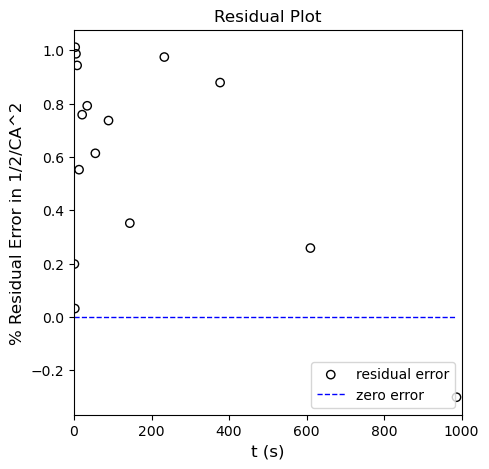

In [8]:
#####################################################################################################
# Make sure that we have the correct definition for CA0                                             #
#####################################################################################################

CA0   = 10.0

#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/(2*CAdata**2) - 1/(2*CA0**2)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = tdata.reshape(len(tdata), 1)

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
k3b    = m                            #slope is equal to k
CIk3b  = CIm                          #Confidence interval on k3   

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k3']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2 ,  k3b]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4E} +/- {CIm:0.4E}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4E} +/- {CIb:0.4E}')
    elif label == 'k3':
        print(f'{label:4s} = {value:0.4E} +/- {CIk3b:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 1000)
plt.ylim(0, 0.5)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/2/CA^2', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 1000)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/2/CA^2', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'lower right')
plt.show()


In [9]:
print(f'If we regress the slope and the intercept, we get k3 = {k3:10.8f} +/- {CIk3:10.8f}')
print(f'If we regress the slope not the intercept, we get k3 = {k3b:10.8f} +/- {CIk3b:10.8f}')

If we regress the slope and the intercept, we get k3 = 0.00044674 +/- 0.00000119
If we regress the slope not the intercept, we get k3 = 0.00044713 +/- 0.00000105
